In [301]:



train_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/3136/train.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528004576&Signature=i3EJD%2FmW%2BVBYKZMLlyhwWg%2Bwv0A6aCeInBC1WYZkKpGNZnhdHUMFwN9NpcRYU9Bk6Rg%2BKzoaqILW5QDI63z8TathqmhgzrWk18O7B3ixLVPHdIqOfaDPyD9dm%2BCFgBP0Iy9FU1B4yWAI0GfymIXQF2fCJjHJZYG4nHOTjmFQwPW1SkBOCyWAe0itNQXBHTv8ETrf7lyiCFvJJZ%2BqDBp7lOkhFua3Fu3lyuUxfLNOdoVMaiNDL5c%2B3pVm7QfSWJyQQylRbeCTfviKDXVt1Qbh3PZ0%2BbQ2S7AENZ4YOGYURkR7z9f5lkRDzLEtqwDdsfT8jqoGtgDcqJbcTTCzq7YpYg%3D%3D'
df = pd.read_csv(train_url)
test_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/3136/test.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528014652&Signature=Svj8okCs2qGEFUbNv3a9g3ZmNSXciO%2B3mJWdXIxcMLvTzR41Gcne%2BGStUV%2BOD6x8pZwJKMv%2BiHlFtYob%2F2eTDKt9AaHclwWB8osr6pv9h%2Bq%2Fi6JDWXsxAwb8eodlYfh3Yv4Xtp4vcknqG%2FoP3Br%2FbqxYlBMEXST4CQL%2BBysri%2BKoSzRkASg%2BR1KKgPhw0Cp0G%2BwV5OWQ67HJRLyqROUbG9ZBkjzLqOGTYSqafH1Cej8Rfr7fVHxReaYzjtNbWhGIkc%2BncnctXQh6wc7Ri1pWiTiJ3bYbRqcIrk6ZJWDesrpcebx7MbmqCARW5DXgNb36olu0SEziE5fDO5BkCpufBg%3D%3D'
test_df = pd.read_csv(test_url)

In [9]:
"""
- 그냥 슬쩍 보기에, 유용하다고 생각되는 것들은 Pclass, Sex, Age 로 나뉨. 
"""
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [345]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
"""
- cabin값이 있고, 없을때의 survival rate가 0.4 정도 차이남.
- 각각, sibling+spouse의 수, parent+child 의 수인데, 개별 class별로 차이가 발생함. 
- Age를 continuous하게 하지 않고, categorical로 처리했더니 정확도가 오르는 것을 알 수 있음. 
"""
def preprocessingX(inputDF):
    def find_preName(inputS):
        inputS = inputS.lower()
        if '.' in inputS:
            r = inputS[inputS.find(",")+2:inputS.find(".")]
            if r in ['mrs', 'miss', 'mr', 'master']:
                return  r
            else:
                return 'none'
        else:
            return "none"
    r = pd.get_dummies(inputDF['Pclass'], prefix='Pclass').join(
        pd.get_dummies(inputDF['Sex'], prefix='Sex')).join(
        pd.get_dummies(inputDF['Cabin'].isnull(), prefix='Cab')).join(
        pd.get_dummies((inputDF['SibSp'] + inputDF['Parch']), prefix='fam')).join(
        inputDF['Age'].fillna(inputDF['Age'].mean())//16).join(
        inputDF['Fare'].fillna(inputDF['Fare'].mean())).join(
        pd.get_dummies(inputDF['Name'].apply(find_preName))).join(
        pd.get_dummies(inputDF['Embarked'], prefix='Em'))
    r = pd.DataFrame(MinMaxScaler().fit_transform(r), columns=r.columns)
    return r

X = preprocessingX(df)
Y = df['Survived']

#train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=0.8, random_state=42)

models = {
    "logisticReg":GridSearchCV(LogisticRegression(), {'penalty':['l1', 'l2'], }),
    #"DecTreeClf":DecisionTreeClassifier(),
    "neural-net":GridSearchCV(MLPClassifier(), {'hidden_layer_sizes':[[10, 50, 10],
                                                                      [16, 32, 64, 32, 16, 8, 4], 
                                                                      [10, 20, 40, 80, 160, 80, 40, 20, 10],
                                                                      [16, 128, 16]
                                                                     ], 
                                                'activation':['relu', 'logistic'], 
                                                'solver':['adam']
                                               }, cv=2),
    'kneighborsClf':GridSearchCV(KNeighborsClassifier(), {'n_neighbors':[2, 3, 5, 10]}),
    'svc':GridSearchCV(SVC(), {'kernel':['rbf', 'poly', 'linear', 'sigmoid'], 'C':[1, 10]}),
    'randomforest':GridSearchCV(RandomForestClassifier(), {'n_estimators':[2, 3, 5, 10, 50, 75, 100]}),
    'AdaBoostClassifier':GridSearchCV(AdaBoostClassifier(), {'n_estimators':[2, 3, 5, 10]}),
    'GaussianNB':GaussianNB(), 
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(), 
    'GaussianProcessClassifier':GaussianProcessClassifier()
}

print('-------------------')
for k, m in models.items():
    m.fit(train_X, train_Y)
    print(k)
    y_true = Y
    y_pred = m.predict(X)
    print("train accuracy: {}".format( accuracy_score(y_true, y_pred) ))
    print("F1 score: {}".format( f1_score(y_true, y_pred)))
    print("--------")

test_df['Survived'] = models['neural-net'].predict(preprocessingX(test_df))
test_df[['PassengerId', 'Survived']].to_csv('titanic_submit.csv', index=False)

-------------------
logisticReg
train accuracy: 0.8338945005611672
F1 score: 0.7784431137724551
--------


/Users/frhyme/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/frhyme/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/frhyme/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


neural-net
train accuracy: 0.8451178451178452
F1 score: 0.779552715654952
--------
kneighborsClf
train accuracy: 0.8451178451178452
F1 score: 0.7759740259740259
--------
svc
train accuracy: 0.8305274971941639
F1 score: 0.7666151468315301
--------
randomforest
train accuracy: 0.9270482603815937
F1 score: 0.9042709867452136
--------
AdaBoostClassifier
train accuracy: 0.8226711560044894
F1 score: 0.7620481927710844
--------
GaussianNB
train accuracy: 0.4276094276094276
F1 score: 0.5721476510067114
--------
QuadraticDiscriminantAnalysis
train accuracy: 0.7586980920314254
F1 score: 0.7309136420525657
--------


/Users/frhyme/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


GaussianProcessClassifier
train accuracy: 0.8451178451178452
F1 score: 0.7759740259740259
--------


In [351]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
"""
- cabin값이 있고, 없을때의 survival rate가 0.4 정도 차이남.
- 각각, sibling+spouse의 수, parent+child 의 수인데, 개별 class별로 차이가 발생함. 
- Age를 continuous하게 하지 않고, categorical로 처리했더니 정확도가 오르는 것을 알 수 있음. 
"""
def preprocessingX(inputDF):
    def find_preName(inputS):
        inputS = inputS.lower()
        if '.' in inputS:
            r = inputS[inputS.find(",")+2:inputS.find(".")]
            if r in ['mrs', 'miss', 'mr', 'master']:
                return  r
            else:
                return 'none'
        else:
            return "none"
    r = pd.get_dummies(inputDF['Pclass'], prefix='Pclass').join(
        pd.get_dummies(inputDF['Sex'], prefix='Sex')).join(
        inputDF['Age'].fillna(inputDF['Age'].mean())//16).join(
        inputDF['Fare'].fillna(inputDF['Fare'].mean()))
    r = pd.DataFrame(MinMaxScaler().fit_transform(r), columns=r.columns)
    return r

X = preprocessingX(df)
Y = df['Survived']

#train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=0.8, random_state=42)

models = {
    "logisticReg":GridSearchCV(LogisticRegression(), {'penalty':['l1', 'l2'], }),
    #"DecTreeClf":DecisionTreeClassifier(),
    "neural-net":GridSearchCV(MLPClassifier(), {'hidden_layer_sizes':[[10, 50, 10],
                                                                      [16, 32, 64, 32, 16, 8, 4], 
                                                                      [10, 20, 40, 80, 160, 80, 40, 20, 10],
                                                                      [16, 128, 16]
                                                                     ], 
                                                'activation':['relu', 'logistic'], 
                                                'solver':['adam']
                                               }, cv=2),
    'kneighborsClf':GridSearchCV(KNeighborsClassifier(), {'n_neighbors':[2, 3, 5, 10]}),
    'svc':GridSearchCV(SVC(), {'kernel':['rbf', 'poly', 'linear', 'sigmoid'], 'C':[1, 10]}),
    'randomforest':GridSearchCV(RandomForestClassifier(), {'n_estimators':[2, 3, 5, 10, 50, 75, 100]}),
    'AdaBoostClassifier':GridSearchCV(AdaBoostClassifier(), {'n_estimators':[2, 3, 5, 10]}),
    'GaussianNB':GaussianNB(), 
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(), 
    'GaussianProcessClassifier':GaussianProcessClassifier()
}

print('-------------------')
for k, m in models.items():
    m.fit(X, Y)
    print(k)
    y_true = Y
    y_pred = m.predict(X)
    print("train accuracy: {}".format( accuracy_score(y_true, y_pred) ))
    print("F1 score: {}".format( f1_score(y_true, y_pred)))
    print("--------")

-------------------
logisticReg
train accuracy: 0.7901234567901234
F1 score: 0.715372907153729
--------


/Users/frhyme/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


neural-net
train accuracy: 0.7946127946127947
F1 score: 0.7180277349768875
--------
kneighborsClf
train accuracy: 0.8395061728395061
F1 score: 0.7697262479871176
--------
svc
train accuracy: 0.7867564534231201
F1 score: 0.7103658536585367
--------
randomforest
train accuracy: 0.9180695847362514
F1 score: 0.8905547226386807
--------
AdaBoostClassifier
train accuracy: 0.7867564534231201
F1 score: 0.7103658536585367
--------
GaussianNB
train accuracy: 0.77665544332211
F1 score: 0.7128427128427127
--------
QuadraticDiscriminantAnalysis
train accuracy: 0.7283950617283951
F1 score: 0.5980066445182723
--------


/Users/frhyme/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


GaussianProcessClassifier
train accuracy: 0.7957351290684624
F1 score: 0.7147335423197492
--------


In [270]:
df['isAlone']=(df['SibSp'] + df['Parch']) <1
df.groupby('isAlone')['Survived'].sum()/df.groupby('isAlone')['Survived'].count()

isAlone
False    0.505650
True     0.303538
Name: Survived, dtype: float64

In [114]:
df['Ticket'] #가격, 같은 것일줄 알았는데, 일단은 무슨 의미인지 모르겠음
df['Fare']# 운임요금, 아마도 비싼지 적은지에 따라서 구분이 가능할듯 
df['SibSp']# 이게 가족 뭐였던것 같은데 
df['Parch']# 이것도 가족 뭐 였던 것 같은데 
df[['Cabin', 'Survived']]
df[df['Cabin'].isnull()]['Survived'].mean()

0.29985443959243085

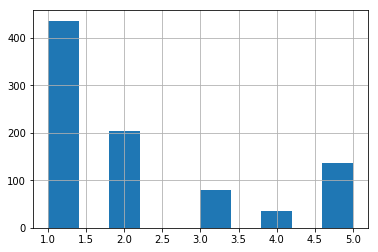

In [253]:
def FareToCat(lst):
    r = lst//14
FareToCat(df['Fare'])
df['Fare'].apply(lambda x: x//14+1 if x//14 < 5 else 5
).hist()
plt.show()

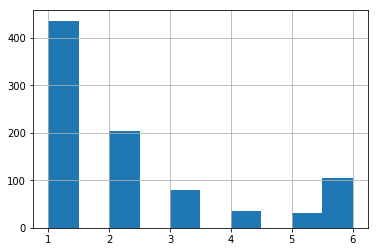

FareCat
1.0    0.254587
2.0    0.428571
3.0    0.412500
4.0    0.472222
5.0    0.580645
6.0    0.723810
Name: Survived, dtype: float64

In [256]:
df['FareCat'] = df['Fare'].apply(lambda x: x//14+1 if x//14 < 6 else 6)
df['FareCat'].hist()
plt.show()
df.groupby('FareCat')['Survived'].sum()/df.groupby('FareCat')['Survived'].count()

In [221]:
df.groupby('PreName')['Survived'].sum()/df.groupby('PreName')['Survived'].count()

KeyError: 'PreName'

In [178]:
df['Fare'].min()

0.0

In [225]:
def find_preName(inputS):
    inputS = inputS.lower()
    if '.' in inputS:
        r = inputS[inputS.find(",")+2:inputS.find(".")]
        if r in ['mrs', 'miss', 'mr', 'master']:
            return  r
        else:
            return 'none'
    else:
        return "none"
df['preName'] = df['Name'].apply(find_preName)

df.groupby('preName')['Survived'].sum()/df.groupby('preName')['Survived'].count()
#df.groupby('preName')['Survived'].count()

preName
master    0.575000
miss      0.697802
mr        0.156673
mrs       0.792000
none      0.444444
Name: Survived, dtype: float64

In [161]:
df.groupby('preName')['Survived'].count()
"""
master, mrs, miss 의 경우 수도 많고 생존률이 높은 반면 
mr의 경우 생존율이 매우 낮음 
"""

preName
capt              1
col               2
don               1
dr                7
jonkheer          1
lady              1
major             2
master           40
miss            182
mlle              2
mme               1
mr              517
mrs             125
ms                1
rev               6
sir               1
the countess      1
Name: Survived, dtype: int64

In [168]:
df.groupby('Embarked')['Survived'].sum()/df.groupby('Embarked')['Survived'].count()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [198]:
1.2//2

0.0